# Physics - Informed Neural Networks

The main goal of this notebook is testing **Physics - Informed Neural Network (PINN)**, one of the recent frontiers of Machine Learning, which are used to solve differential equations with high performances in a shorter time interval respect to classical methods.

### Approach
Let's introduce the method that will be implemented in the following cells:
- Inputs: differential equation and the initial conditions of the system
- Outputs: estimated solution $x(t)$

A feasible solution have to approximate the "true" solution of the differential equation with high precision ($x_{\mathrm{PINN}}(t;\theta) \approx x(t)$), while respecting the initial\
(and/or boundary) conditions. For this reason the **loss function** of the problem should incoporate all those aspects:

$$
\mathcal{L}(\theta) = \mathcal{L}_{IC}(\theta) + \lambda_1 \mathcal{L}_{IC,DER}(\theta)  + \lambda_2 \mathcal{L}_{ODE}(\theta)
$$
where
$$
\mathcal{L}_{IC}(\theta) = \bigl(x_{\mathrm{PINN}}(t=0;\theta) - x(t=0)\bigr)^2
$$
and
$$
\mathcal{L}_{IC,DER}(\theta) = \left(\dfrac{d x_{\mathrm{PINN}}}{d t}(t=0; \theta) - \dfrac{d x}{d t}(t=0) \right)^2
$$

represent the difference between the reconstructed and the actual initial condition (here implemented as *soft conditions*) and are called **boundary loss**,

$$
\mathcal{L}_{ODE}(\theta) = \frac{1}{N} \sum^{N}_{i} \left( \hat{P}_{ODE}\, \bigl[x_{\mathrm{PINN}}(t_{i};\theta) \bigr] \right)^2
$$
is called **physics loss** and estimates whether PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire investigation domain.

The training parameters ($\lambda_1$, $\lambda_2$) are used to balence the terms in the loss function and should be carefully adjusted to ensure stability during training.

In [1]:
import time
from itertools import chain
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

%matplotlib inline
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [2]:
# Define the Neural Network model

class PINN(nn.Module):
    def __init__(
        self,
        *,
        input_channels: int,
        output_channels: int,
        hidden_channels: int,
        hidden_layers: int = 3
    ) -> None:
        
        super(PINN, self).__init__()
        
        model = [
            nn.Linear(input_channels, hidden_channels),
            nn.Tanh()
        ]

        for _ in range(hidden_layers):
            model += [
                nn.Linear(hidden_channels, hidden_channels),
                nn.Tanh()
            ]
        
        model += [nn.Linear(hidden_channels, output_channels)]
        
        self.model = nn.Sequential(*model)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass"""

        return self.model(x)

## 1. Damped Harmonic Oscillator

The **harmonic oscillator** is one of the most extensively studied system in physics. Nearly everything that returns to its equilibrium position after being displaced can be described by a harmonic oscillator, so it can be found in wave propagation, electric circuits and so on.

Here we consider the easiest version of the problem, the spring pendulum, where a mass $m$ is coupled with a spring $k$; The potential energy of the system depends quadratically on the displacement $x$ from the equilibrium position and the resulting force is proportional to the displacement itself.\
Based on these considerations and the addition of a *damping force*, the equation of motion reads:
$$
\dfrac{d^2 x}{dt^2} + 2\gamma \dfrac{d x}{dt} + w_0^2 x = 0
$$
where $ w_0^2 = k \,/\, m $ and $\gamma$ is the damping coefficient.

This is a classical example of *linear differential equations with constant coefficients* of the second order. It can be solved rather easily with standard methods, such as the exponential ansatz, giving the general solution:
$$
x(t) = A e^{-\gamma t} \cos{(w_1 t + \phi)}
$$
where
$$
w_1^2 = w_0^2 - \gamma^2 
$$

**N.B:** Here we are considering the following initial conditions:
$$
u(t=0)=1, \quad u'(t=0)=0.
$$


More information on the problem and resolution methods can be found here:\
https://en.wikipedia.org/wiki/Harmonic_oscillator \
https://beltoforion.de/en/harmonic_oscillator/

A visual representation of the system and displacement found online:
<p align="center">
  <img src="images/spring_mass_oscillator.gif" width=40% height=40%>
</p>

### 1.1 Solvind the ODE

In this first example, we propose a simple PINN (multilayer perceptron with few hidden layers) to solve the Ordinary Differential Equation of the damped harmonic oscillator and show a comparison between the PINN result and the true solution.

In [3]:
def position(t: torch.Tensor, gamma: float, w0: float,) -> torch.Tensor:
    
    """Return the displacement at time t for given harmonic motion"""
    
    w = np.sqrt(w0**2 - gamma**2)

    phi = np.arctan(- gamma / w)
    A = 1. / np.cos(phi)
    
    return A * torch.exp(-gamma * t) * torch.cos(w * t + phi)

In [4]:
# Define physical variables and parameters
gamma = 2.5
w0 = 15

# Weight factors for loss
lambda_der, lambda_ode = 0.1, 0.01

# Training parameters
lr = 0.005
training_steps = 20000

# Generate vectors and convert to tensors
t = torch.linspace(0, 1, 100, dtype=torch.float32, requires_grad=True).view(-1,1)
x_exact = position(t, gamma, w0)

# Boundary condition at t = 0
t_bd = torch.tensor(0., dtype=torch.float32, requires_grad=True).view(-1,1)

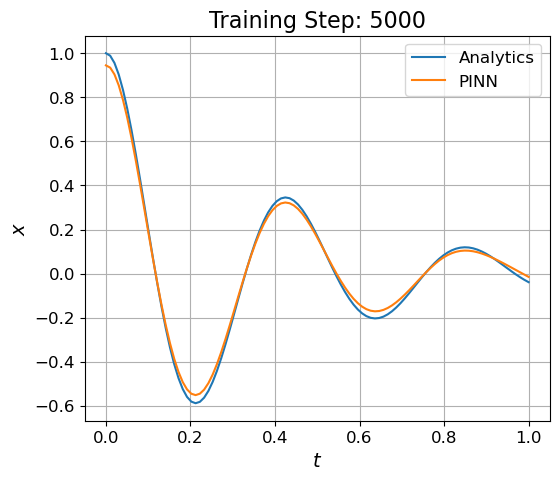

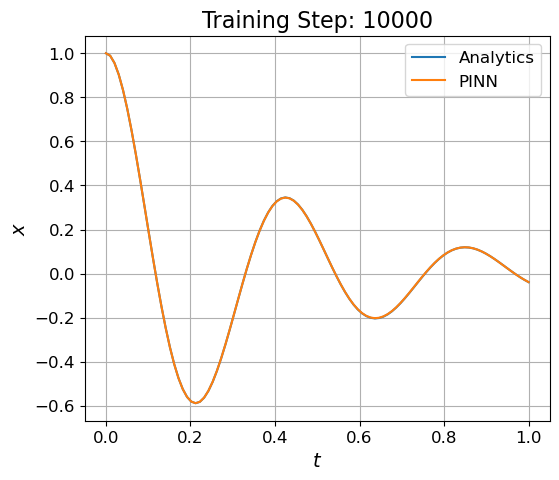

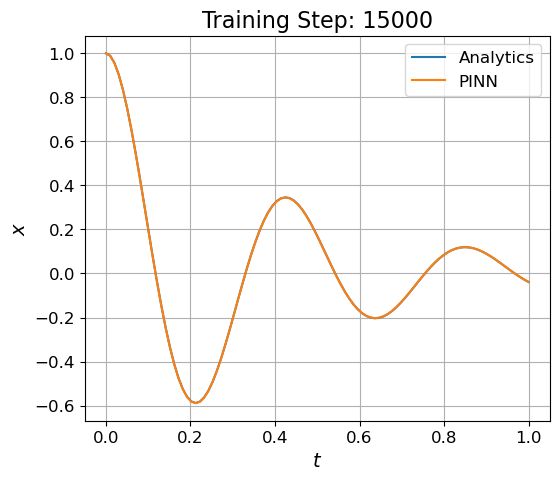

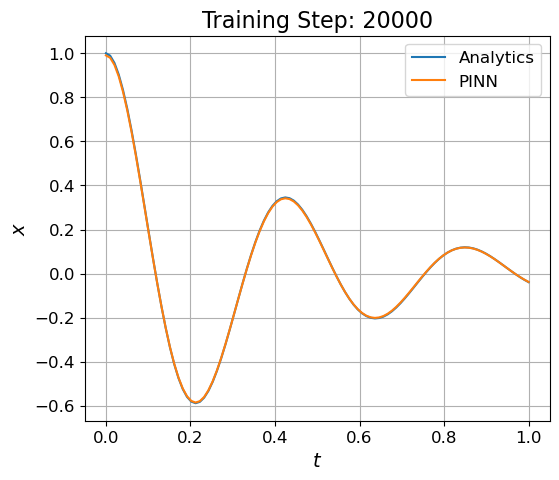

In [5]:
# Define and train model
model = PINN(input_channels=1, output_channels=1, hidden_channels=32, hidden_layers=3)
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

list_loss = []

for ts in range(training_steps):
    optimiser.zero_grad()

    # 1: Boundary loss on function
    x_bd = model(t_bd)
    loss_bd = torch.square(torch.squeeze(x_bd) - 1.) # BD: x(0) = 1

    # 2: Boundary loss on derivative
    dx_dt = torch.autograd.grad(x_bd, t_bd, torch.ones_like(x_bd), create_graph=True)[0]
    loss_bd_der = torch.square(torch.squeeze(dx_dt)) # BD: x'(0) = 0
    
    # 3: Physics Loss (ODE)
    x = model(t)
    dx_dt = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, torch.ones_like(dx_dt), create_graph=True)[0]
    loss_ode = torch.mean(torch.square(d2x_dt2 + 2 * gamma * dx_dt + w0**2 * x))
    
    # Total Loss
    loss_tot = loss_bd + lambda_der * loss_bd_der + lambda_ode * loss_ode

    loss_tot.backward()
    optimiser.step()
    
    list_loss.append(loss_tot.item())

    if (ts + 1) % 5000 == 0:
        plt.figure(figsize=(6, 5))
        plt.plot(t.detach().numpy(), x_exact.detach().numpy(), label="Analytics")
        plt.plot(t.detach().numpy(), model(t).detach().numpy(), label="PINN")
        plt.xlabel("$t$")
        plt.ylabel("$x$")
        plt.title(f"Training Step: {ts + 1}")
        plt.legend()
        plt.grid(True)
        plt.show()

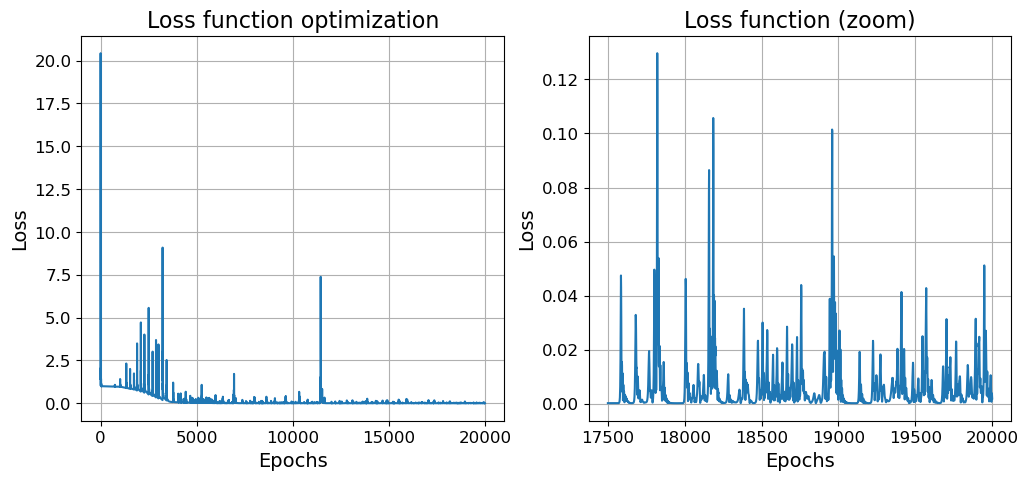

In [6]:
# Plot the loss evolution
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(list(range(1,len(list_loss) + 1)), list_loss)
ax[0].set_title("Loss function optimization")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].grid(True)

ax[1].plot(list(range(1,len(list_loss) + 1))[17500:], list_loss[17500:])
ax[1].set_title("Loss function (zoom)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].grid(True)
plt.show()

### 1.2 Solving the ODE at high frequency (standard)

In the previous section, we saw the excellent results achieved by the network in solving the equation at low frequency (a couple of periods in the selected domain). Now, we are interested in a broader investigation:\
what happens if a much higher frequency is considered? Is the previous model enough complex to reconstruct the function?

**Spoiler**: we need to add other parameters in the model (i.e. increase width and depth of the model) and increase the number of training point to achieve the same accuracy.

In [24]:
# Define physical variables and parameters
gamma = 4
w0 = 50

# Weight factors for loss
lambda_der, lambda_ode = 0.1, 0.001

# Training parameters
lr = 0.001
training_steps = 70000

# Generate vectors and convert to tensors
t = torch.linspace(0, 1, 400, dtype=torch.float32, requires_grad=True).view(-1,1)
x_exact = position(t, gamma, w0)

# Boundary condition at t = 0
t_bd = torch.tensor(0., dtype=torch.float32, requires_grad=True).view(-1,1)

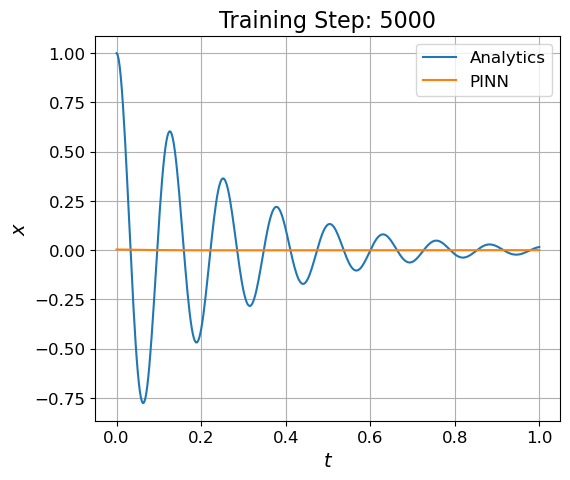

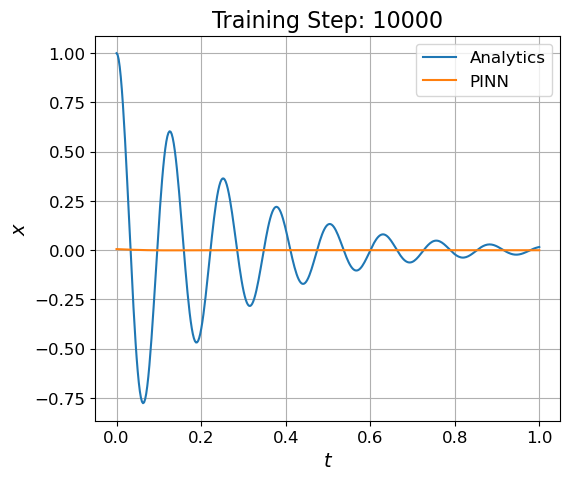

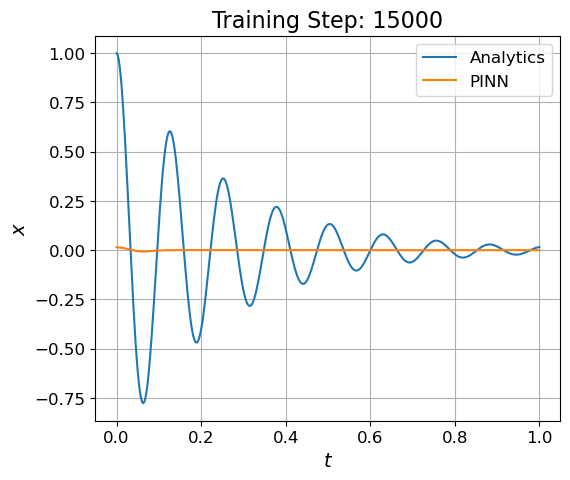

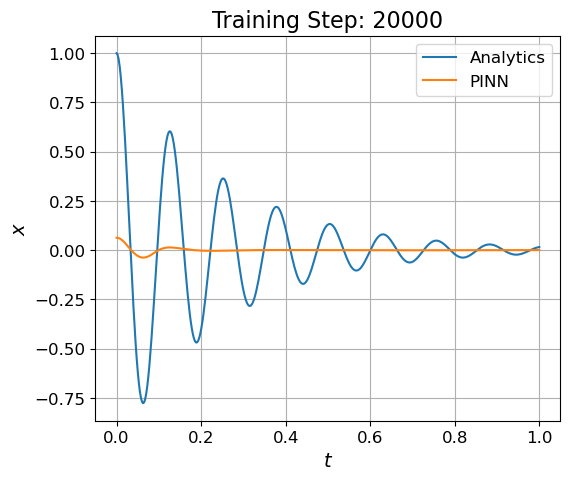

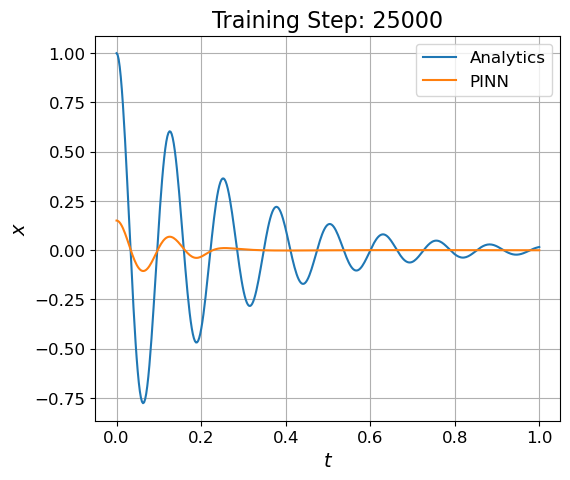

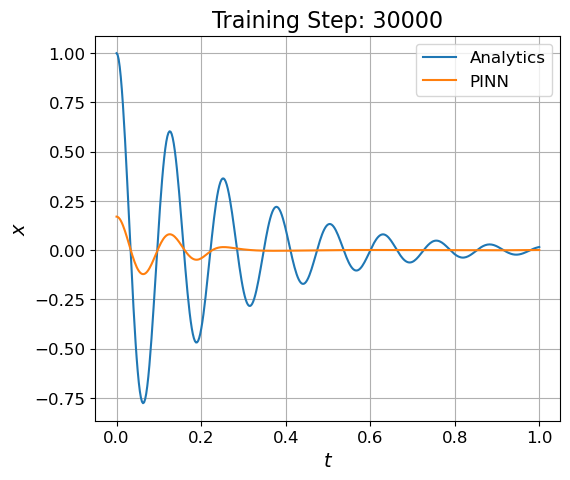

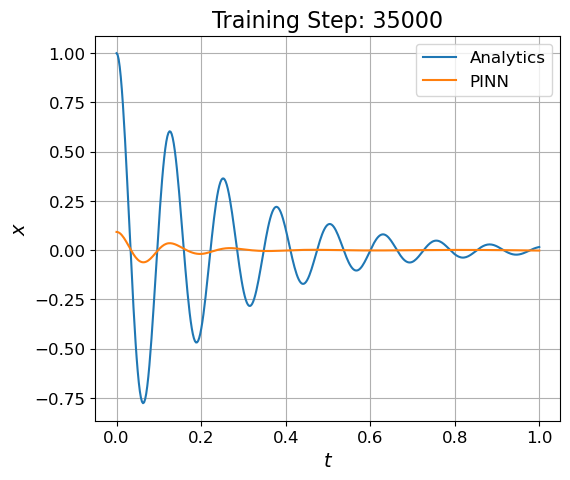

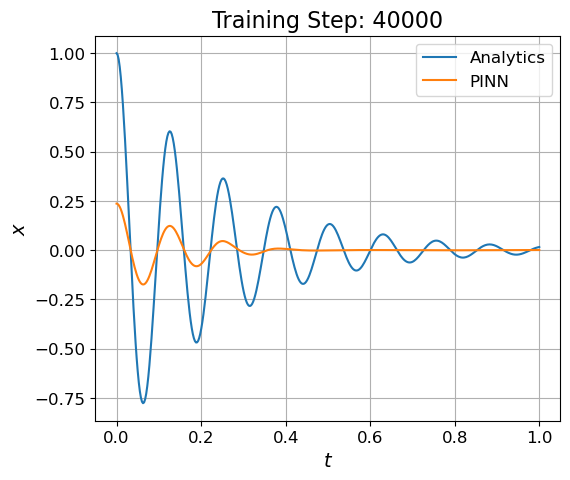

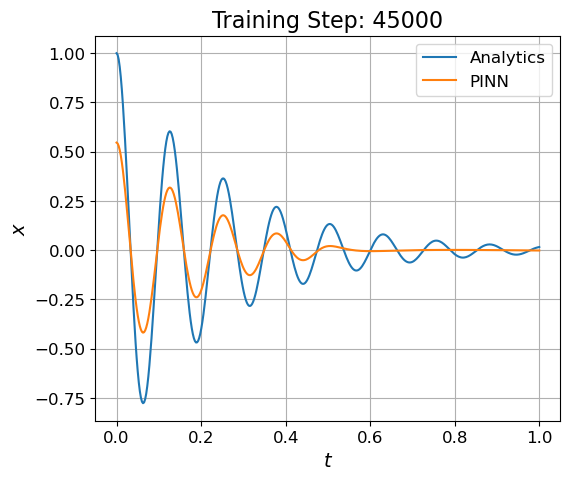

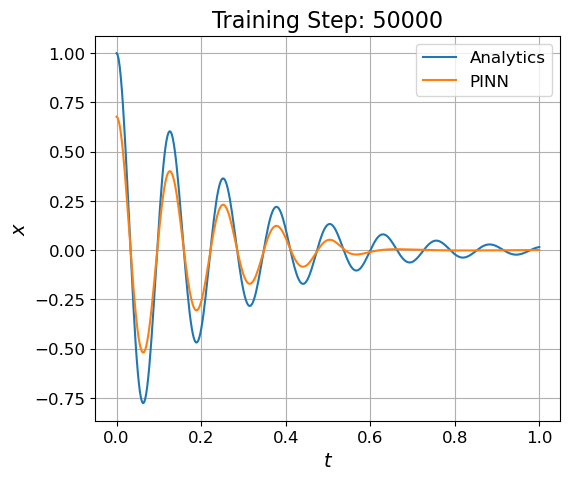

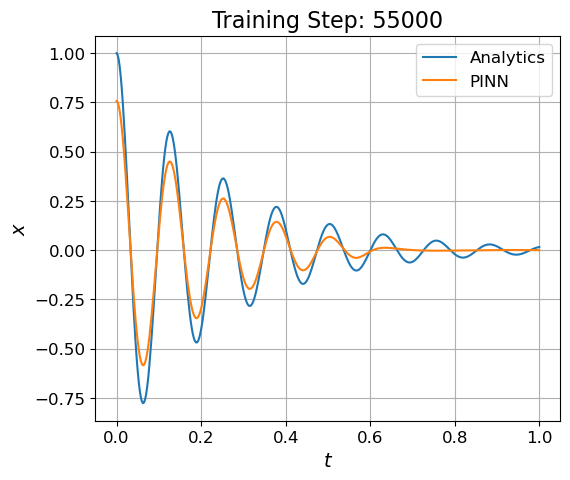

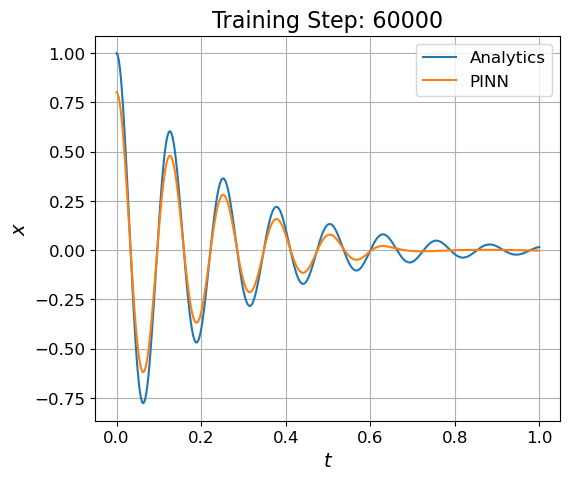

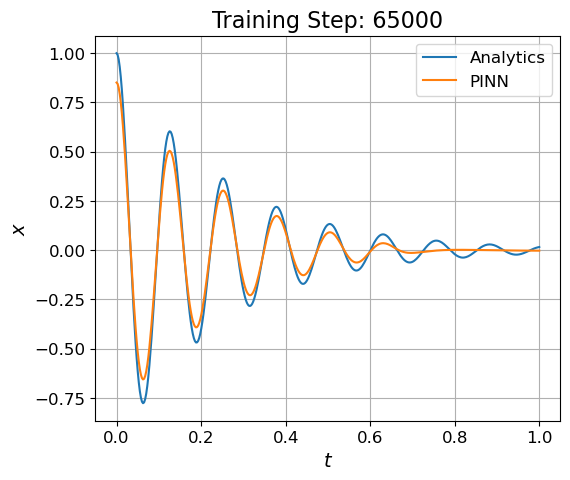

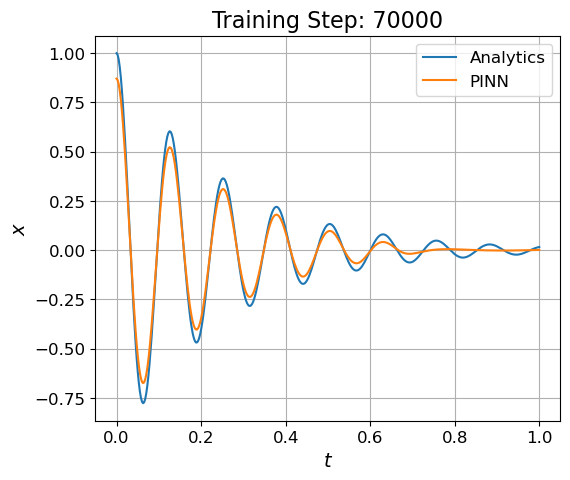

In [25]:
# Define and train model
model = PINN(input_channels=1, output_channels=1, hidden_channels=48, hidden_layers=4)
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

list_loss = []

for ts in range(training_steps):
    optimiser.zero_grad()

    # 1: Boundary loss on function
    x_bd = model(t_bd)
    loss_bd = torch.square(torch.squeeze(x_bd) - 1.) # BD: x(0) = 1

    # 2: Boundary loss on derivative
    dx_dt = torch.autograd.grad(x_bd, t_bd, torch.ones_like(x_bd), create_graph=True)[0]
    loss_bd_der = torch.square(torch.squeeze(dx_dt)) # BD: x'(0) = 0
    
    # 3: Physics Loss (ODE)
    x = model(t)
    dx_dt = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, torch.ones_like(dx_dt), create_graph=True)[0]
    loss_ode = torch.mean(torch.square(d2x_dt2 + 2 * gamma * dx_dt + w0**2 * x))
    
    # Total Loss
    loss_tot = loss_bd + lambda_der * loss_bd_der + lambda_ode * loss_ode

    loss_tot.backward()
    optimiser.step()
    
    list_loss.append(loss_tot.item())

    if (ts + 1) % 5000 == 0:
        plt.figure(figsize=(6, 5))
        plt.plot(t.detach().numpy(), x_exact.detach().numpy(), label="Analytics")
        plt.plot(t.detach().numpy(), model(t).detach().numpy(), label="PINN")
        plt.xlabel("$t$")
        plt.ylabel("$x$")
        plt.title(f"Training Step: {ts + 1}")
        plt.legend()
        plt.grid(True)
        plt.show()

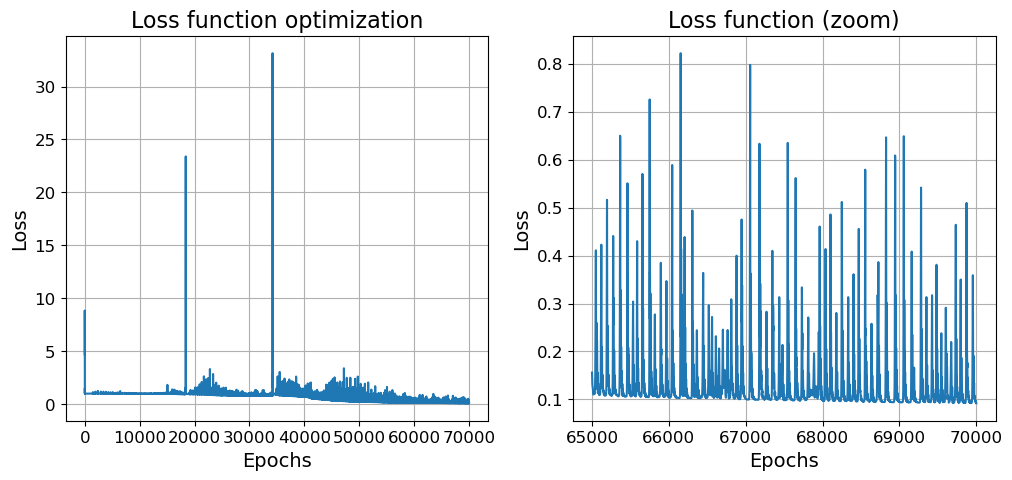

In [26]:
# Plot the loss evolution
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(list(range(1,len(list_loss) + 1)), list_loss)
ax[0].set_title("Loss function optimization")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].grid(True)

ax[1].plot(list(range(1,len(list_loss) + 1))[65000:], list_loss[65000:])
ax[1].set_title("Loss function (zoom)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].grid(True)
plt.show()

### 1.3 Solving the ODE at high frequency (ansatz formulation)

An alternative approach to speed up convergence is the *ansatz formulation*, in which we assume something about the solution (in general we may take examples from similar problems or physical intuition). Here, we suppose that the periodic part of ther solution is a sine with some learnable parameters.

$$
\hat x(t; \theta, \alpha, \beta) = x_{\mathrm{PINN}}(t;\theta)  \sin (\alpha t + \beta) \approx x(t)
$$

**N.B:** Notice that if the parameter $\alpha$ is similar to the true frequency of the system, the learned function $x_{\mathrm{PINN}}$ will be only the exponential damping, otherwise this is not guaranteed!

In [10]:
# Define physical variables and parameters
gamma = 4
w0 = 50

# Weight factors for loss
lambda_der, lambda_ode = 0.1, 0.001

# Training parameters
lr = 0.001
training_steps = 30000

# Generate vectors and convert to tensors
t = torch.linspace(0, 1, 200, dtype=torch.float32, requires_grad=True).view(-1,1)
x_exact = position(t, gamma, w0)

# Boundary condition at t = 0
t_bd = torch.tensor(0., dtype=torch.float32, requires_grad=True).view(-1,1)

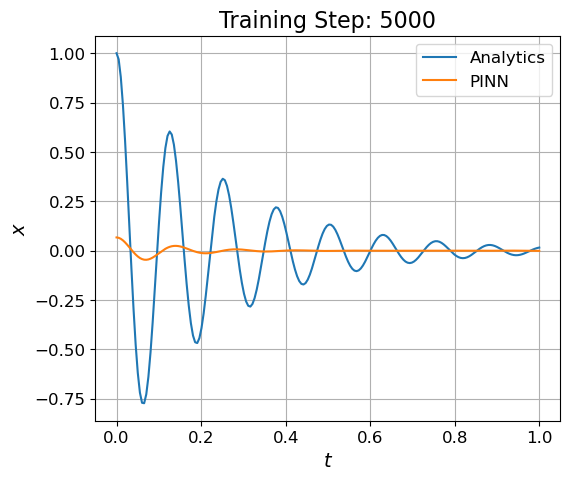

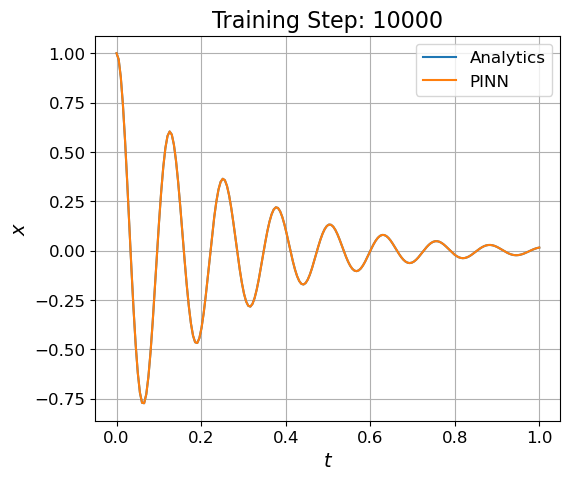

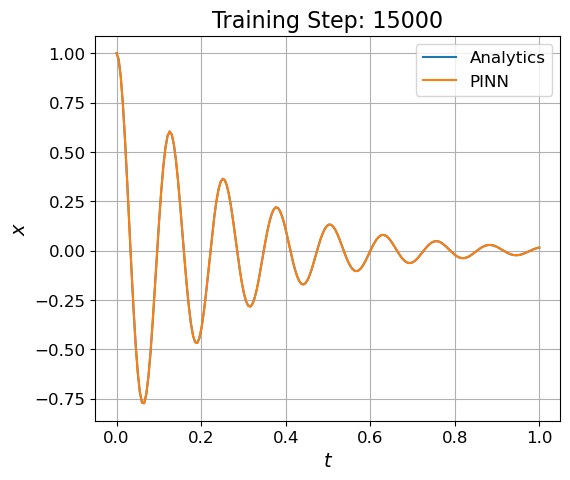

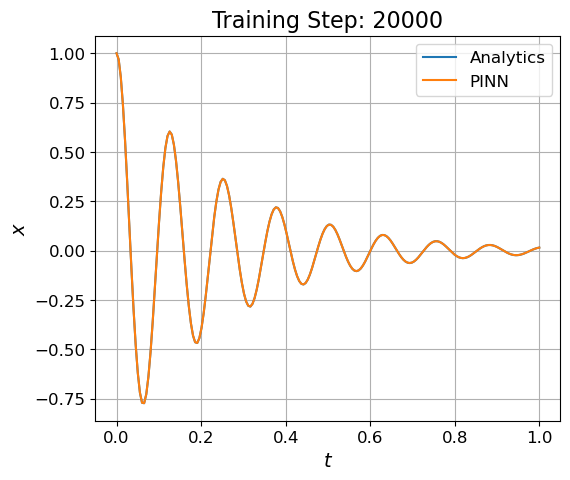

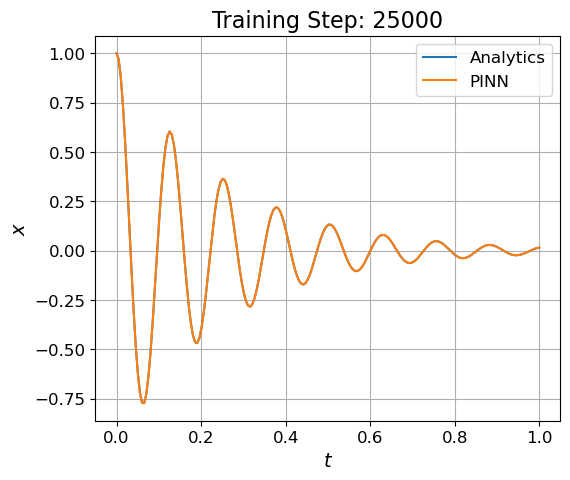

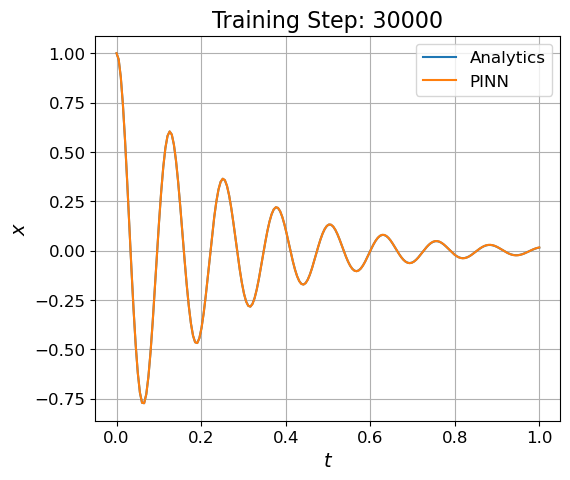

In [11]:
model = PINN(input_channels=1, output_channels=1, hidden_channels=32, hidden_layers=3)
alpha_opt = torch.nn.Parameter(40 * torch.ones(1, requires_grad=True))
beta_opt = torch.nn.Parameter(torch.ones(1, requires_grad=True))

optimiser = torch.optim.Adam(chain(model.parameters(), [alpha_opt,beta_opt]), lr=lr)

list_loss = []

for ts in range(training_steps):
    optimiser.zero_grad()
  
    # 1: Boundary loss on function
    x_bd = model(t_bd) * torch.sin(alpha_opt * t_bd + beta_opt)
    loss_bd = torch.square(torch.squeeze(x_bd) - 1.) # BD: x(0) = 1

    # 2: Boundary loss on derivative
    dx_dt = torch.autograd.grad(x_bd, t_bd, torch.ones_like(x_bd), create_graph=True)[0]
    loss_bd_der = torch.square(torch.squeeze(dx_dt)) # BD: x'(0) = 0
    
    # 3: Physics Loss (ODE)
    x = model(t) * torch.sin(alpha_opt * t + beta_opt)
    dx_dt = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, torch.ones_like(dx_dt), create_graph=True)[0]
    loss_ode = torch.mean(torch.square(d2x_dt2 + 2 * gamma * dx_dt + w0**2 * x))
    
    # Total Loss
    loss_tot = loss_bd + lambda_der * loss_bd_der + lambda_ode * loss_ode

    loss_tot.backward()
    optimiser.step()
    
    list_loss.append(loss_tot.item())

    if (ts + 1) % 5000 == 0:
        plt.figure(figsize=(6, 5))
        plt.plot(t.detach().numpy(), x_exact.detach().numpy(), label="Analytics")
        plt.plot(t.detach().numpy(), (model(t)*torch.sin(alpha_opt * t + beta_opt)).detach().numpy(), label="PINN")
        plt.xlabel("$t$")
        plt.ylabel("$x$")
        plt.title(f"Training Step: {ts + 1}")
        plt.legend()
        plt.grid(True)
        plt.show()

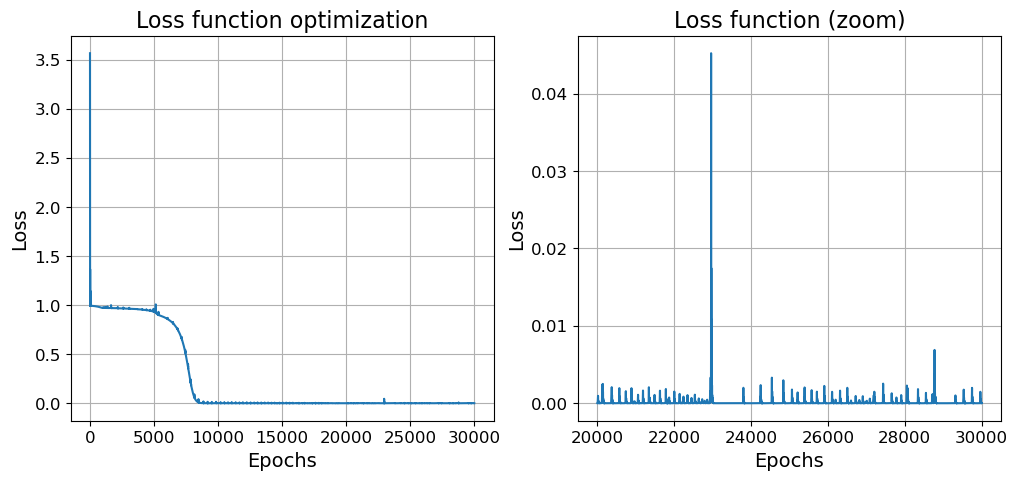

In [12]:
# Plot the loss evolution
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(list(range(1,len(list_loss) + 1)), list_loss)
ax[0].set_title("Loss function optimization")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].grid(True)

ax[1].plot(list(range(1,len(list_loss) + 1))[20000:], list_loss[20000:])
ax[1].set_title("Loss function (zoom)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].grid(True)
plt.show()

In [13]:
print(alpha_opt)
print(beta_opt)

Parameter containing:
tensor([49.8396], requires_grad=True)
Parameter containing:
tensor([1.4907], requires_grad=True)


### 1.4 Inferring underlying parameters

Another interesting application of PINNs is the possibility of inferring the underlying (unknown) parameters for a system that is ruled by a known differential equation. The key idea is to treat them as a learnable parameter when training the PINN.

Let's revise the previous method to solve the current problem:
- Inputs: differential equation and measurements of the system's displacement
- Outputs: the optimized parameter(s) (here we'll consider the damping coefficient $\gamma$)

The introduction of a new **loss function** is needed:

$$
\mathcal{L}(\theta, \gamma) = \lambda_{data} \, \mathcal{L}_{data}(\theta) + \lambda_{ODE} \, \mathcal{L}_{ODE}(\theta, \gamma)
$$
where
$$
\mathcal{L}_{data}(\theta) = \frac{1}{M} \sum^{M}_{j} \left( x_{\mathrm{PINN}}(t_{j};\theta) - x_{\mathrm{data}}(t_{j}) \right)^2
$$
is called **data loss** and it makes sure that the function learned by the PINN fits the available observations,
$$
\mathcal{L}_{ODE}(\theta,\gamma) = \frac{1}{N} \sum^{N}_{i} \left( \hat{P}_{ODE}\, \bigl[x_{\mathrm{PINN}}(t_{i};\theta,\gamma) \bigr] \right)^2
$$
is the same **physics loss** employed in the previous experiments.

The training parameters ($\lambda_{data}$, $\lambda_{ODE}$) are used to balence the terms in the loss function and should be carefully adjusted to ensure stability during training.

In [14]:
# Define physical variables and parameters
gamma = 3
w0 = 15

# Loss weighting factors
lambda_data, lambda_ode = 1, 0.001

# Training parameters
lr = 0.002
training_steps = 30000

# Generate vectors and convert to tensors
t = torch.linspace(0, 1, 100, dtype=torch.float32, requires_grad=True).view(-1,1)
x_exact = position(t, gamma, w0)

# Make syntetic data by adding noise to true displacement
t_data = torch.linspace(0, 1, 100, dtype=torch.float32).view(-1,1)
x_data = position(t_data, gamma, w0) + 0.05 * torch.randn(t_data.size(dim=0), 1)

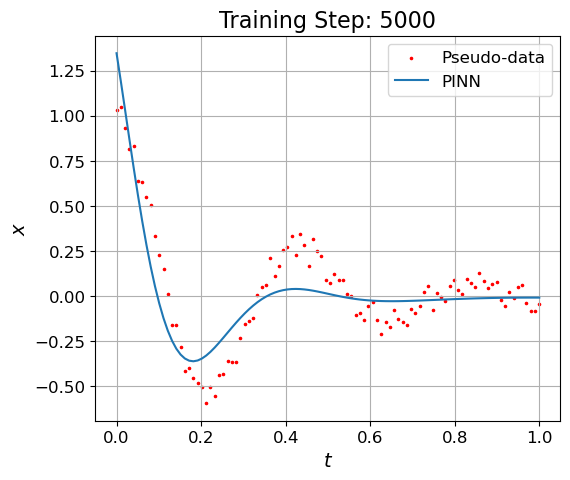

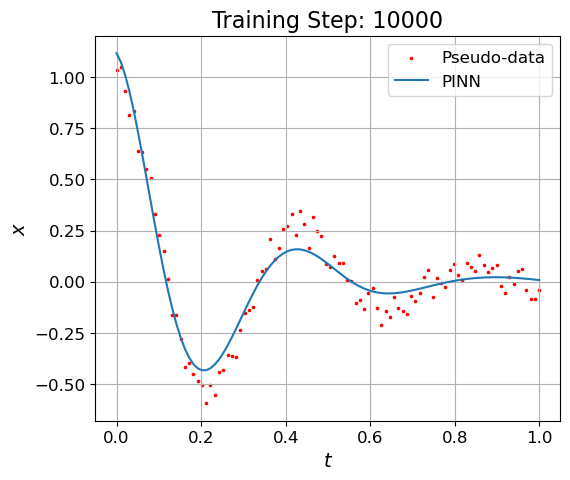

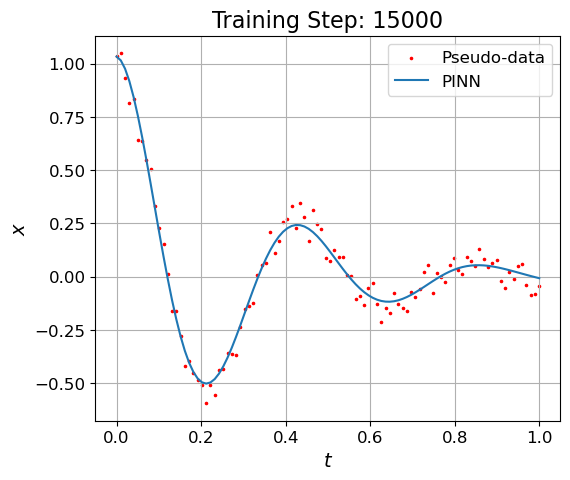

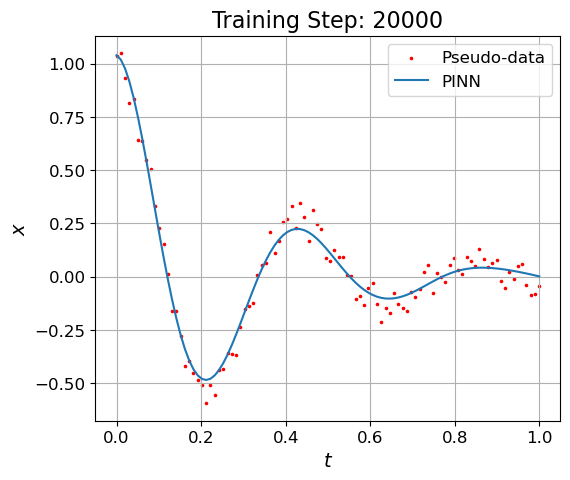

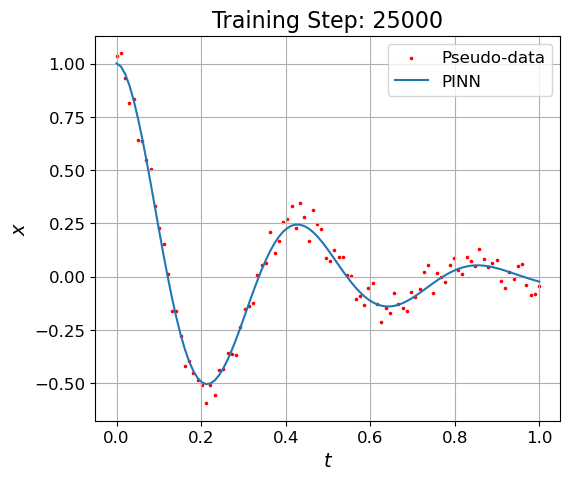

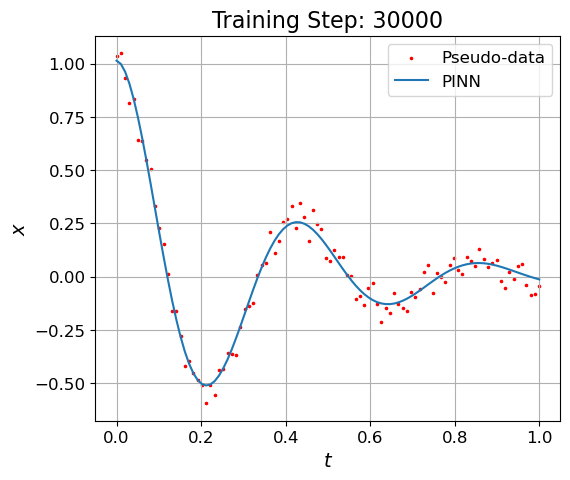

In [15]:
# Define and train model
model = PINN(input_channels=1, output_channels=1, hidden_channels=48, hidden_layers=3)
gamma_opt = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
optimiser = torch.optim.Adam(chain(model.parameters(), [gamma_opt]), lr=lr)
loss = nn.MSELoss()

list_loss, list_gamma = [], []

for ts in range(training_steps):
    optimiser.zero_grad()

    # 1: Data loss
    x = model(t_data)
    loss_data = loss(x, x_data)
    
    # 2: Physics Loss (ODE)
    x = model(t)
    dx_dt = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, torch.ones_like(dx_dt), create_graph=True)[0]
    loss_ode = loss(d2x_dt2 + 2 * gamma_opt * dx_dt + w0**2 * x, torch.zeros_like(x))
    
    # Total Loss
    loss_tot = lambda_data * loss_data + lambda_ode * loss_ode

    loss_tot.backward()
    optimiser.step()
    
    list_loss.append(loss_tot.item())
    list_gamma.append(gamma_opt.item())

    if (ts + 1) % 5000 == 0:
        plt.figure(figsize=(6, 5))
        plt.scatter(t_data.detach().numpy(), x_data.detach().numpy(), label="Pseudo-data", color='r', s=2.5)
        plt.plot(t.detach().numpy(), model(t).detach().numpy(), label="PINN")
        plt.xlabel("$t$")
        plt.ylabel("$x$")
        plt.title(f"Training Step: {ts + 1}")
        plt.legend()
        plt.grid(True)
        plt.show()

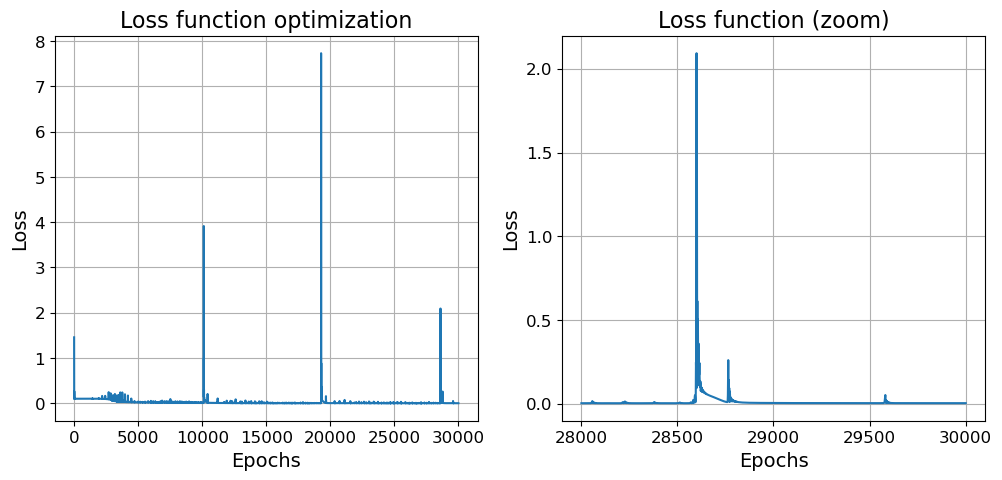

In [16]:
# Plot the loss evolution
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(list(range(1,len(list_loss) + 1)), list_loss)
ax[0].set_title("Loss function optimization")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].grid(True)

ax[1].plot(list(range(1,len(list_loss) + 1))[28000:], list_loss[28000:])
ax[1].set_title("Loss function (zoom)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].grid(True)
plt.show()

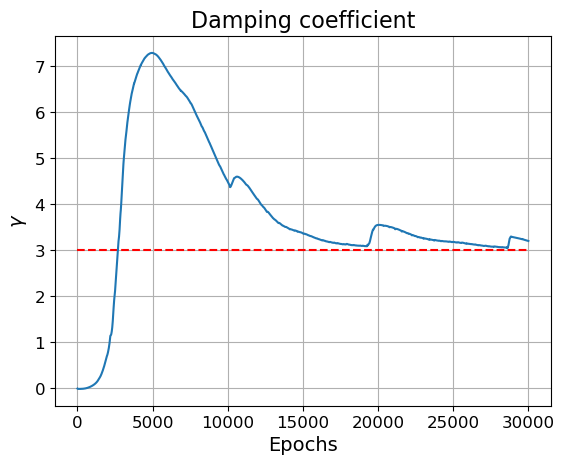

In [17]:
# Plot parameter optimization
plt.hlines(gamma, 1, len(list_gamma) + 1, color='red', linestyle='dashed')
plt.plot(list(range(1,len(list_gamma) + 1)), list_gamma)
plt.xlabel("Epochs")
plt.ylabel("$\gamma$")
plt.title(f"Damping coefficient")
plt.grid(True)
plt.show()

## 2. Driven Harmonic Oscillator

An interesting extension of the previous problem can be found by adding a periodic driving function to the system:
$$
\dfrac{d^2 x}{dt^2} + 2\gamma \dfrac{d x}{dt} + w_0^2 x = F_0 \cos (w t + \phi_d)
$$

When a damped oscillator is driven by an external force, the solution to the equation of motion has two parts, namely a transient and a steady-state part, which must be used together to fit the physical boundary conditions of the problem. We'll not dwell on how to solve the new differential equation and report only the final displacement equation with the initial parameters:

$$
x(t) = A_1 e^{-\gamma t} \sin{(w_1 t + \phi_1)} + A_2 \cos (w t - \phi_2)
$$
where
$$
w_1^2 = w_0^2 - \gamma^2 
$$

$$
A_1 = \frac{x_0 - A_2 \cos\phi_2}{\sin\phi_1}
$$

$$
A_2 = \frac{F_0}{\sqrt{(w_0^2 - w^2)^2 + 4 \gamma^2 w^2}}
$$

$$
\phi_1 = \arctan \Bigl(\frac{w_1 (x_0 - A_2 \cos\phi_2)}{v_0 + \gamma (x_0 - A_2 \cos\phi_2) - A_2 w \sin\phi_2} \Bigr)
$$

$$
\phi_2 = \arctan \Bigl(\frac{w \gamma}{w_0^2 - w^2} \Bigr) - \phi_d
$$

In [18]:
def position_driving(
    t: torch.Tensor,
    gamma: float,
    w0: float,
    w: float,
    phid: float,
    F0: float,
    x0: float,
    v0: float
) -> torch.Tensor:
    
    """Return the dislacement at time t for given harmonic motion with external force (aka driven harmonic motion)"""
    
    w1 = np.sqrt(w0**2 - gamma**2)

    phi2 = np.arctan(w * gamma / (w0**2 - w**2)) - phid
    A2 = F0 / np.sqrt((w0**2 - w**2)**2 + 4 * gamma**2 * w**2)
    
    phi1 = np.arctan( (w1 * (x0 - A2 * np.cos(phi2))) / (v0 + gamma * (x0 - A2 * np.cos(phi2)) - A2 * w * np.sin(phi2)))
    A1 = (x0 - A2 * np.cos(phi2) ) / np.sin(phi1)
    
    return A1 * torch.exp(-gamma * t) * torch.sin(w1 * t + phi1) + A2 * torch.cos(w * t - phi2)

In [19]:
# Define physical variables and parameters
gamma = 2
w0 = 20
w = 16
phid = 0.4
F0 = 60
x0 = 1
v0 = 0

# weighting factors
lambda_der, lambda_ode = 0.1, 0.001

# Training parameters
lr = 0.005
training_steps = 30000

# Generate vectors and convert to tensors
t = torch.linspace(0, 2, 200, dtype=torch.float32, requires_grad=True).view(-1,1)
x_exact = position_driving(
    t=t,
    gamma=gamma,
    w0=w0,
    w=w,
    phid=phid,
    F0=F0,
    x0=x0,
    v0=v0
)

# Boundary condition at t = 0
t_bd = torch.tensor(0., dtype=torch.float32, requires_grad=True).view(-1,1)

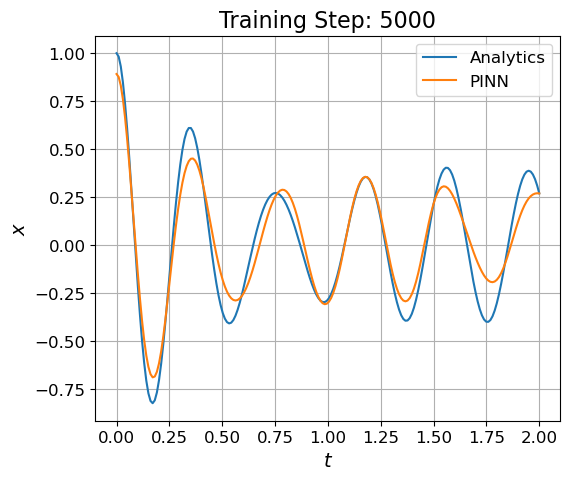

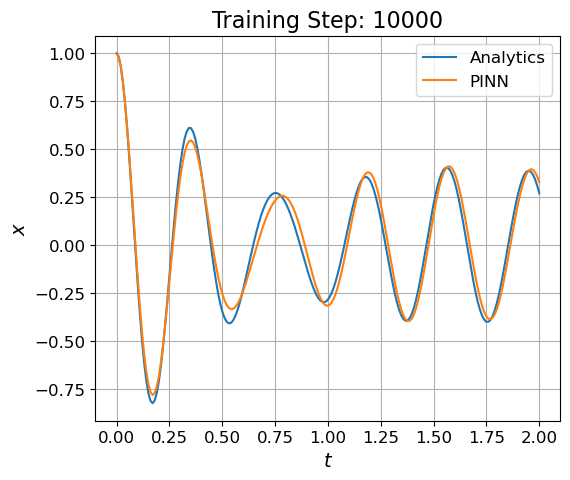

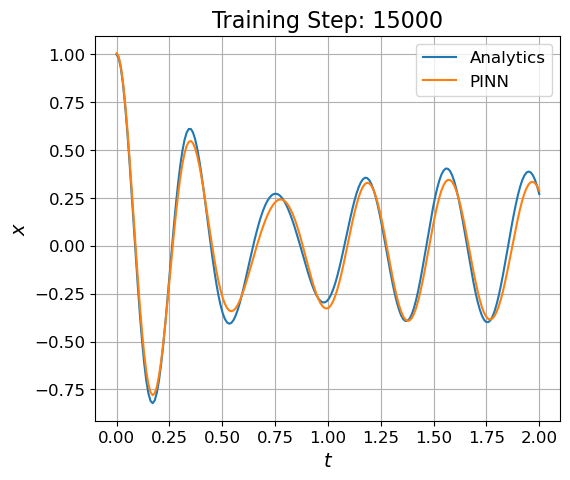

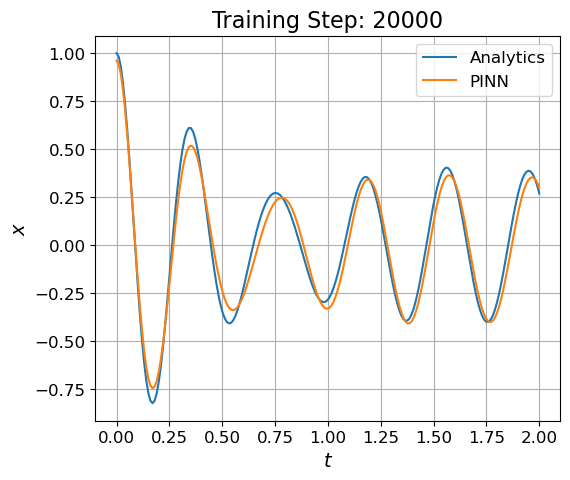

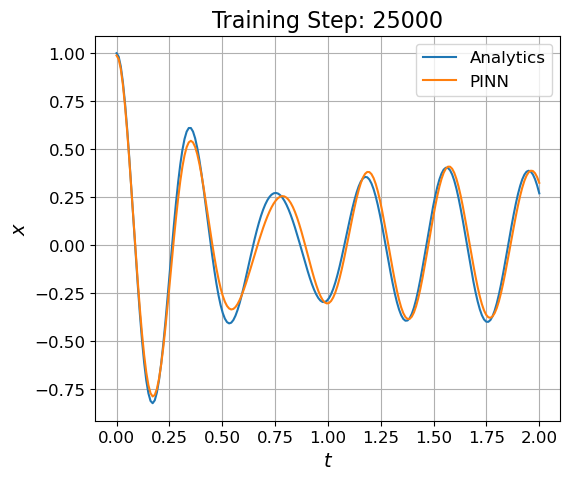

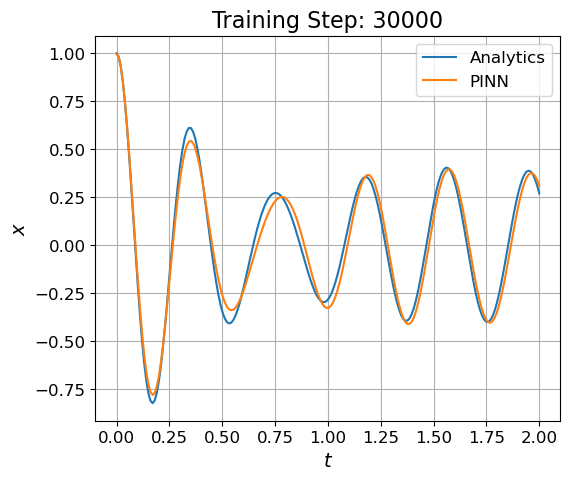

In [20]:
# Define and train model
model = PINN(input_channels=1, output_channels=1, hidden_channels=46, hidden_layers=5)
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
loss = nn.MSELoss()

list_loss = []

for ts in range(training_steps):
    optimiser.zero_grad()

    # 1: Boundary loss on function
    x_bd = model(t_bd)
    loss_bd = torch.square(torch.squeeze(x_bd) - 1.) # BD: x(0) = 1

    # 2: Boundary loss on derivative
    dx_dt = torch.autograd.grad(x_bd, t_bd, torch.ones_like(x_bd), create_graph=True)[0]
    loss_bd_der = torch.square(torch.squeeze(dx_dt)) # BD: x'(0) = 0
    
    # 3: Physics Loss (ODE)
    x = model(t)
    dx_dt = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, torch.ones_like(dx_dt), create_graph=True)[0]
    loss_ode = loss((d2x_dt2 + 2 * gamma * dx_dt + w0**2 * x - F0 * torch.cos(w*t + phid)), torch.zeros_like(x))
    
    # Total Loss
    loss_tot = loss_bd + lambda_der * loss_bd_der + lambda_ode * loss_ode

    loss_tot.backward()
    optimiser.step()
    
    list_loss.append(loss_tot.item())

    if (ts + 1) % 5000 == 0:
        plt.figure(figsize=(6, 5))
        plt.plot(t.detach().numpy(), x_exact.detach().numpy(), label="Analytics")
        plt.plot(t.detach().numpy(), model(t).detach().numpy(), label="PINN")
        plt.xlabel("$t$")
        plt.ylabel("$x$")
        plt.title(f"Training Step: {ts + 1}")
        plt.legend()
        plt.grid(True)
        plt.show()

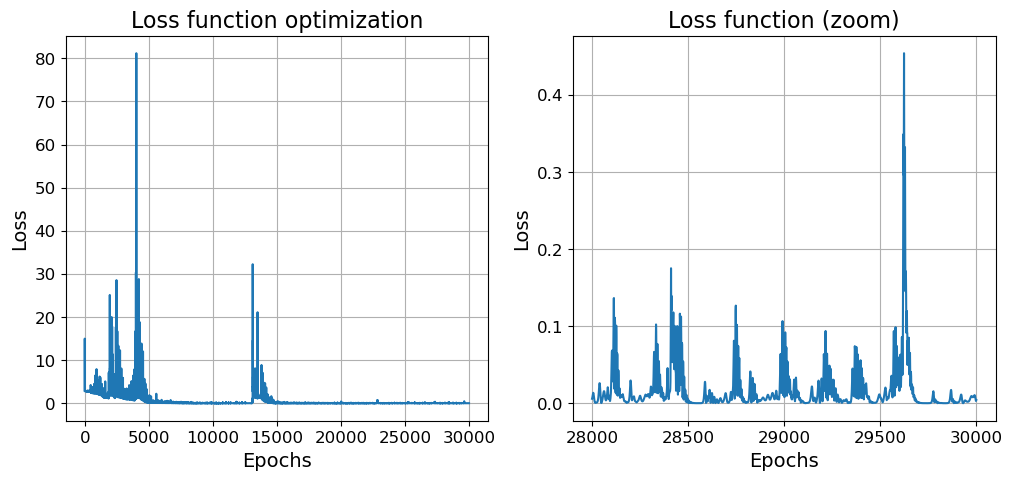

In [21]:
# Plot the loss evolution
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(list(range(1,len(list_loss) + 1)), list_loss)
ax[0].set_title("Loss function optimization")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].grid(True)

ax[1].plot(list(range(1,len(list_loss) + 1))[28000:], list_loss[28000:])
ax[1].set_title("Loss function (zoom)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].grid(True)
plt.show()